In [1]:
from PIL import Image
import torch
from models.model import MyModel

/opt/conda/envs/mmm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import argparse
args = argparse.Namespace(
    # Model setting
    float_type="bfloat16",
    image_model_name="microsoft/swinv2-large-patch4-window12to16-192to256-22kto1k-ft",
    image_model_train=False,
    language_model_name="google/flan-t5-xl",
    language_model_train=False,
    ffn=True,
    transformer_d_model=768,
    transformer_d_ff=3072,
    transformer_d_kv=64,
    transformer_num_heads=12,
    transformer_num_layers=2,
    transformer_num_decoder_layers=0,
    loc_vocab_size=1600,
    additional_vocab_size=10000,
    vae_ckpt_path='',
    max_source_length=512,
    max_target_length=512,
    # Train setting
    phase="classify", 
    datasets=["openimage"],
    loss='CrossEntropy',
    # Dir setting
    root_dir="/data/dataset/",
    result_dir="results/categorization/openimage/enc2_dec0_xl/Linear50_1e-4/",
)

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
model = MyModel(args).to(device)
model.load(result_name='epoch_10.pth')

Loading checkpoint shards: 100%|██████████| 2/2 [02:56<00:00, 88.20s/it] 


In [5]:
from transformers import AutoTokenizer
from torchvision import transforms
src_tokenizer = AutoTokenizer.from_pretrained(args.language_model_name, model_max_length=args.max_source_length)
tgt_tokenizer = AutoTokenizer.from_pretrained(args.language_model_name, model_max_length=args.max_target_length, use_fast=True, extra_ids=0, additional_special_tokens =[f"<extra_id_{i}>" for i in range(100)] + [f"<loc_{i}>" for i in range(args.loc_vocab_size)] + [f"<add_{i}>" for i in range(args.additional_vocab_size)])
resize=256
src_transforms = transforms.Compose([
    transforms.Resize((resize, resize)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                            std=[0.229, 0.224, 0.225]),
])
tgt_transforms = transforms.Compose([
    transforms.Resize((resize, resize)),
    transforms.ToTensor(),
])

In [6]:
import numpy as np
def custom_to_pil(x):
  x = x.detach().cpu().numpy()
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  x = (((x.transpose(1, 2, 0) * std) + mean) * 255.).astype(np.uint8)

  x = Image.fromarray(x)
  if not x.mode == "RGB":
    x = x.convert("RGB")
  return x

In [7]:
from PIL import ImageDraw
def show_result(dataset, idx=10):
    src_image, tgt_image, src_text, tgt_text = dataset[idx]
    print(src_text)
    scale = 256 / 40
    bias = scale // 2
    left_top = int(src_text.split('<loc_')[-2].rstrip('>'))
    right_bottom = int(src_text.split('<loc_')[-1].split('>')[0])
    with torch.no_grad():
        src_image = src_image.unsqueeze(0).to(device)
        src_input = src_tokenizer(src_text, padding="longest", max_length=args.max_source_length, return_tensors="pt")
        src_text = src_input['input_ids'].to(device)
        src_attention_mask = torch.ones_like(src_text, device=device)

        pil = custom_to_pil(src_image[0])
        display(pil)
        # 四角を描画
        draw = ImageDraw.Draw(pil)
        draw.rectangle((left_top%40*scale+bias, left_top//40*scale+bias, right_bottom%40*scale+bias, right_bottom//40*scale+bias), fill=None, outline='red', width=3)
        display(pil)
        pred = model(src_image, src_text, src_attention_mask, return_loss=False)
        pred = torch.softmax(pred, dim=1).detach().cpu()
        # predの値で１、２、３位を表示
        topk = torch.topk(pred, 3, dim=1)
        print("GT:", num_to_label[tgt_text])
        for i, (value, indice) in enumerate(zip(topk.values[0], topk.indices[0])):
            print(f'{i+1}位: {num_to_label[int(indice)]} ({value.item()})')

## OpenImage

In [14]:
import os
from data import get_dataset
args.root_dir = '/data/dataset/'
val_dataset = get_dataset(args, dataset_name='openimage', phase='val', src_tokenizer=src_tokenizer)

label_to_num_file_path = os.path.join(args.root_dir, 'openimage', 'label_to_num.csv')
with open(label_to_num_file_path) as f:
    label_to_num = f.readlines()
label_to_num = [l.strip().split(',') for l in label_to_num]
num_to_label = {int(l[1]): l[0] for l in label_to_num}

What is the category of the region <loc_93><loc_984> ?


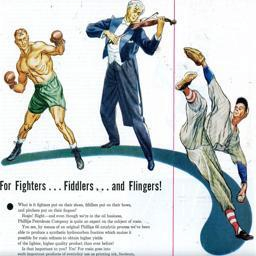

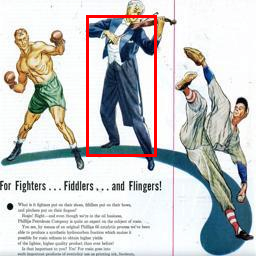

GT: Clothing
1位: Man (0.490234375)
2位: Clothing (0.490234375)
3位: Boy (0.0081787109375)
What is the category of the region <loc_387><loc_1317> ?


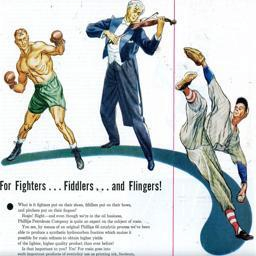

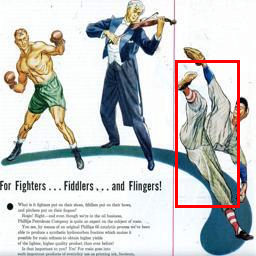

GT: Clothing
1位: Clothing (0.64453125)
2位: Man (0.345703125)
3位: Person (0.00592041015625)
What is the category of the region <loc_840><loc_963> ?


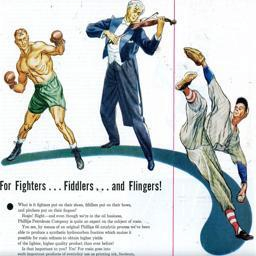

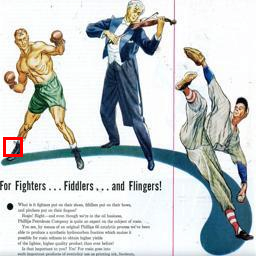

GT: Footwear
1位: Footwear (0.47265625)
2位: Human face (0.392578125)
3位: Clothing (0.09326171875)


In [16]:
for i in range(3):
    show_result(val_dataset, idx=i+10)

# MSCOCO

In [11]:
import os
from data import get_dataset
args.root_dir = '/data01'
val_dataset = get_dataset(args, dataset_name='mscoco', phase='val', src_tokenizer=src_tokenizer)

label_to_num_file_path = os.path.join(args.root_dir, 'mscoco', 'cat.csv')
with open(label_to_num_file_path) as f:
    label_to_num = f.readlines()

label_to_num = label_to_num[1:]
num_to_label = {int(l.split(',')[0]):l.removesuffix('\n').split(',')[2] for l in label_to_num}

In [ ]:
for i in range(3):
    show_result(val_dataset, idx=i)